Developed a cryptographic system combining Kyber polynomial encryption with Huffman coding for secure image transmission. Implemented polynomial arithmetic for encryption and used Huffman coding for image compression and decompression. Successfully demonstrated secure image encoding, encryption, and decoding, ensuring image fidelity.

References:

Blogs:-
https://cryptographycaffe.sandboxaq.com/posts/kyber-01/

https://cryptographycaffe.sandboxaq.com/posts/kyber-sca/

https://cryptographycaffe.sandboxaq.com/posts/ntt-01/

https://cryptographycaffe.sandboxaq.com/posts/ntt-02/

Codes:-
https://colab.research.google.com/drive/1cKhtI-1PtfpShS7Af24j3RQWbQJxIeiH#scrollTo=H5vsV6F9OtQD

https://colab.research.google.com/drive/1BiKO0MxubAWxs0K1TgQzC9DR4vetd8pS#scrollTo=A30UXanelqN8

In [ ]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

import random

In [ ]:
def add_poly(a, b, q):
  result = [0] * max(len(a), len(b))
  for i in range(max(len(a), len(b))):
    if i < len(a):
      result[i] += a[i]
    if i < len(b):
      result[i] += b[i]
    result[i] %= q
  return result


def inv_poly(a, q):
  return list(map(lambda x: -x % q, a))


def sub_poly(a, b, q):
  return add_poly(a, inv_poly(b, q), q)


def mul_poly_simple(a, b, f, q):
  tmp = [0] * (len(a) * 2 - 1)


  for i in range(len(a)):
    # perform a_i * b
    for j in range(len(b)):
      tmp[i + j] += a[i] * b[j]

  # take polynomial modulo f
  # since Kyber's poly modulus is always x^n + 1,
  # we can efficiently compute the remainder
  degree_f = len(f) - 1
  for i in range(degree_f, len(tmp)):
    tmp[i - degree_f] -= tmp[i]
    tmp[i] = 0

  # take coefficients modulo q
  tmp = list(map(lambda x: x % q, tmp))
  return tmp[:degree_f]
q = 17 # plain modulus
f = [1, 0, 0, 0, 1] # poly modulus, x**4 + 1
p1=[1,2,3,4]
p2=[5,6,7,8]
print(mul_poly_simple(p1, p2, f, q))

[12, 15, 2, 9]


In [ ]:
def add_vec(v0, v1, q):
  assert(len(v0) == len(v1)) # sizes need to be the same

  result = []

  for i in range(len(v0)):
    result.append(add_poly(v0[i], v1[i], q))

  return result


def mul_vec_simple(v0, v1, f, q):
  assert(len(v0) == len(v1)) # sizes need to be the same

  degree_f = len(f) - 1
  result = [0 for i in range(degree_f - 1)]

  # textbook vector inner product
  for i in range(len(v0)):
    result = add_poly(result, mul_poly_simple(v0[i], v1[i], f, q), q)

  return result


def mul_mat_vec_simple(m, a, f, q):
  result = []

  # textbook matrix-vector multiplication
  for i in range(len(m)):
    result.append(mul_vec_simple(m[i], a, f, q))

  return result


def transpose(m):
  result = [[None for i in range(len(m))] for j in range(len(m[0]))]

  for i in range(len(m)):
    for j in range(len(m[0])):
      result[j][i] = m[i][j]

  return result

In [ ]:
def encrypt(A, t, m_b, f, q, r, e_1, e_2):
  half_q = int(q / 2 + 0.5)
  m = list(map(lambda x: x * half_q, m_b))

  u = add_vec(mul_mat_vec_simple(transpose(A), r, f, q), e_1, q)
  v = sub_poly(add_poly(mul_vec_simple(t, r, f, q), e_2, q), m, q)

  return u, v

In [ ]:
def decrypt(s, u, v, f, q):
  m_n = sub_poly(v, mul_vec_simple(s, u, f, q), q)

  half_q = int(q / 2 + 0.5)
  def round(val, center, bound):
    dist_center = np.abs(center - val)
    dist_bound = min(val, bound - val)
    return center if dist_center < dist_bound else 0

  m_n = list(map(lambda x: round(x, half_q, q), m_n))
  m_b = list(map(lambda x: x // half_q, m_n))

  return m_b

In [ ]:
# Baby Kyber params
q = 17 # plain modulus
f = [1, 0, 0, 0, 1] # poly modulus, x**4 + 1

s = [[0, 1, -1, -1], [0, -1, 0, -1]] # secret key, [-x**3-x**2+x, -x**3-x]
A = [[[11, 16, 16, 6], [3, 6, 4, 9]], [[1, 10, 3, 5], [15, 9, 1, 6]]] # public key
e = [[0, 0, 1, 0], [0, -1, 1, 0]] # noise
m_b = [1, 1, 0, 1, 1, 0, 1, 1] # message in binary

t = add_vec(mul_mat_vec_simple(A, s, f, q), e, q)

r = [[0, 0, 1, -1], [-1, 0, 1, 1]] # blinding vector for encrypt
e_1 = [[0, 1, 1, 0], [0, 0, 1, 0]] # noise vector for encrypt
e_2 = [0, 0, -1, -1] # noise poly for encrypt

u, v = encrypt(A, t, m_b, f, q, r, e_1, e_2)
m_b2 = decrypt(s, u, v, f, q)

assert(m_b == m_b2)
print(t)

[[7, 0, 15, 16], [6, 11, 12, 10]]


In [ ]:
np.random.seed(0xdeadbeef)

def test_enc_dec(N, k, f, q):
  degree_f = len(f) - 1

  A = (np.random.random([k, k, degree_f]) * q).astype(int)
  s = (np.random.random([k, degree_f]) * 3).astype(int) - 1
  e = (np.random.random([k, degree_f]) * 3).astype(int) - 1
  t = add_vec(mul_mat_vec_simple(A, s, f, q), e, q)

  failed = 0

  for i in range(N):
    m_b = (np.random.random(degree_f) * 2).astype(int)

    r = (np.random.random([k, degree_f]) * 3).astype(int) - 1
    e_1 = (np.random.random([k, degree_f]) * 3).astype(int) - 1
    e_2 = (np.random.random([degree_f]) * 3).astype(int) - 1

    u, v = encrypt(A, t, m_b, f, q, r, e_1, e_2)
    m_b2 = decrypt(s, u, v, f, q)

    if m_b.tolist() != m_b2:
      failed += 1

  print(f"[k={k}, f={f}, q={q}] Test result: {failed}/{N} failed decryption!")
print(u)
print(v)
print(m_b)
print(m_b2)
test_enc_dec(100, 2, [1, 0, 0, 0, 1], 67)

[[3, 10, 11, 11], [11, 13, 4, 4]]
[15, 8, 6, 7, 8, 0, 8, 8]
[1, 1, 0, 1, 1, 0, 1, 1]
[1, 1, 0, 1, 1, 0, 1, 1]
[k=2, f=[1, 0, 0, 0, 1], q=67] Test result: 0/100 failed decryption!


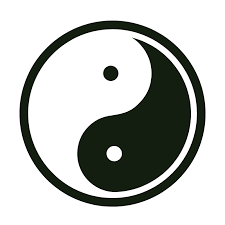

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
img = cv2.imread("test_img.png")
cv2_imshow(img)

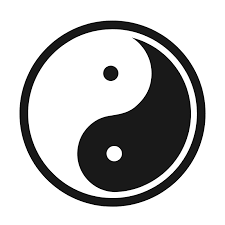

In [ ]:
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(grey)

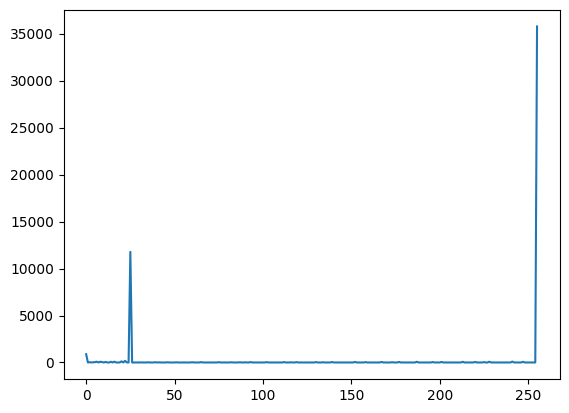

In [ ]:
import matplotlib.pyplot as plt
hist_np, bins = np.histogram(grey.ravel(), 256, [0,256])
bins = bins.astype(int)
plt.plot(hist_np)
plt.show()

In [ ]:
img_flat = np.reshape(grey, (-1))

In [ ]:
bins = list(range(0,256))
bins = [str(format(b, '03d')) for b in bins]
# d = dict(zip(bins[:-1], hist_np[:-1]))
d = dict(zip(bins, hist_np))
#bins (commented)

#d (commented)

In [ ]:
# bins = [str(1),str(2),str(3),str(4),str(5)]
# hist_np = [40,30,15,10,5]

In [ ]:
message = ""
for i in img_flat:
    message += str(format(i, '03d'))

# message = "1223245"

In [ ]:
import heapq
from collections import defaultdict

codes = {}
freq = dict(zip(bins, hist_np))

class MinHeapNode:
    def __init__(self, data, freq):
        self.left = None
        self.right = None
        self.data = data
        self.freq = freq

    def __lt__(self, other):
        return self.freq < other.freq

def HuffmanCodes():
    minHeap = [MinHeapNode(key, freq[key]) for key in freq]
    heapq.heapify(minHeap)

    while len(minHeap) > 1:
        left = heapq.heappop(minHeap)
        right = heapq.heappop(minHeap)
        top = MinHeapNode('$', left.freq + right.freq)
        top.left = left
        top.right = right
        heapq.heappush(minHeap, top)

    def storeCodes(node, currentCode=""):
        if node is None:
            return
        if node.data != '$':
            codes[node.data] = currentCode
        storeCodes(node.left, currentCode + "0")
        storeCodes(node.right, currentCode + "1")

    if minHeap:
        storeCodes(minHeap[0])

    return minHeap[0]

def decode(root, s):
    ans = ""
    curr = root
    for bit in s:
        if bit == '0':
            curr = curr.left
        else:
            curr = curr.right

        # Reached leaf node
        if curr.left is None and curr.right is None:
            ans += str(curr.data)
            curr = root
    return ans

minHeap = HuffmanCodes()

encoded_symbols = list(codes.items())
print("Encoded symbols and their Huffman codes:")
for symbol, code in sorted(encoded_symbols):
    print(f'Symbol: {symbol}, Code: {code}')

encoded_message = ''.join(codes[message[i*3:(i+1)*3]] for i in range(len(message)//3))

print("Encoded message:", encoded_message[:10])

decodedString = decode(minHeap, encoded_message)
print("Original message : ", message[:10])
print("Decoded message : ",decodedString[:10])


Encoded symbols and their Huffman codes:
Symbol: 000, Code: 0010
Symbol: 001, Code: 001101000001111111111011111000111111111111110
Symbol: 002, Code: 001111100
Symbol: 003, Code: 001101000001111111111011101
Symbol: 004, Code: 001100001
Symbol: 005, Code: 001110100
Symbol: 006, Code: 0001011
Symbol: 007, Code: 001101000001111111111011111000111111111111111111111100000011111
Symbol: 008, Code: 0000111
Symbol: 009, Code: 00010011
Symbol: 010, Code: 001101000001111111111011111000111111111111111110
Symbol: 011, Code: 00111011
Symbol: 012, Code: 001101000001111111111011111000111111111111111111111100000001010110111010
Symbol: 013, Code: 00110100000111111111101111100011111111111111101110101111101
Symbol: 014, Code: 0000011
Symbol: 015, Code: 001101000001111111111011111000111111111111111111111100000111
Symbol: 016, Code: 0001010
Symbol: 017, Code: 00110100000111111111101111100011111111111111111111110000001111010
Symbol: 018, Code: 001101000001111111111011100
Symbol: 019, Code: 0011010000011111111

In [ ]:
message

'255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255255

In [ ]:
encoded_message
print(len(encoded_message))
split_strings = [encoded_message[i:i+6] for i in range(0, len(encoded_message), 6)]
residue=split_strings[-1]
split_strings_excluding_last=split_strings[:-1]



79753


In [ ]:
encrypted_data = []
for binary_string in split_strings_excluding_last:
    m_b = [int(bit) for bit in binary_string]  # Convert to list of integers
    u, v = encrypt(A, t, m_b, f, q, r, e_1, e_2)
    encrypted_data.append((u, v))

In [ ]:
encrypted_data

[([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15, 8, 14, 7, 8, 8]),
 ([[3, 10, 11, 11], [11, 13, 4, 4]], [15

In [ ]:
decrypted_strings = []
for u, v in encrypted_data:
    m_b2 = decrypt(s, u, v, f, q)
    decrypted_string = ''.join(str(bit) for bit in m_b2)  # Convert back to string
    decrypted_strings.append(decrypted_string)

In [ ]:
decrypted_strings

['111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',
 '111111',

In [ ]:
final_decrypted_string = ''.join(decrypted_strings) + residue
print(final_decrypted_string==encoded_message)

True


In [ ]:
decodedString = decode(minHeap, final_decrypted_string)

decoded_img = []
for i in range(len(decodedString)//3):
    decoded_img.append(int(decodedString[i*3:(i+1)*3]))

In [ ]:
decoded_img = np.array(decoded_img).reshape(grey.shape)

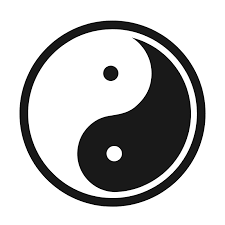

In [ ]:
cv2_imshow(decoded_img)